# California Housing Prices using Tensorflow

* Use the LinearRegressor class in TensorFlow to predict median housing price, at the granularity of city blocks, based on one input feature
* Evaluate the accuracy of a model's predictions using Root Mean Squared Error (RMSE)
* Improve the accuracy of a model by tuning its hyperparameters

In [1]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [2]:
housing = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

We'll randomize the data, just to be sure not to get any pathological ordering effects that might harm the performance of Stochastic Gradient Descent. Additionally, we'll scale median_house_value to be in units of thousands, so it can be learned a little more easily with learning rates in a range that we usually use.

In [4]:
train = housing.reindex(np.random.permutation(housing.index))
train["median_house_value"] /= 1000.0
train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
13093,-121.9,38.0,46.0,2112.0,466.0,1249.0,382.0,2.6,87.0
5436,-118.2,34.1,17.0,821.0,163.0,229.0,164.0,7.4,263.0
1159,-117.1,32.6,26.0,1360.0,309.0,869.0,328.0,3.0,131.6
2123,-117.3,33.2,24.0,1586.0,262.0,912.0,298.0,4.2,150.3
2318,-117.5,34.1,19.0,3155.0,572.0,2482.0,642.0,3.0,113.4


In [5]:
train.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


## First model: 

To start, we're going to use just one numeric input feature, total_rooms. The following code pulls the total_rooms data from our dataset and defines the feature column using numeric_column, which specifies its data is numeric:

In [7]:
# Define the input feature: total_rooms.
my_feature = train[["total_rooms"]]

# Configure a numeric feature column for total_rooms.
feature_columns = [tf.feature_column.numeric_column("total_rooms")]

In [11]:
feature_columns

[_NumericColumn(key='total_rooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [13]:
# Define the label.
targets = train["median_house_value"]

Next, we'll configure a linear regression model using LinearRegressor. We'll train this model using the GradientDescentOptimizer, which implements Mini-Batch Stochastic Gradient Descent (SGD). The learning_rate argument controls the size of the gradient step.
NOTE: To be safe, we also apply gradient clipping to our optimizer via clip_gradients_by_norm. Gradient clipping ensures the magnitude of the gradients do not become too large during training, which can cause gradient descent to fail.

In [14]:
# Use gradient descent as the optimizer for training the model.
my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)

## Input Function:

* we'll convert our pandas feature data into a dict of NumPy arrays. 
* We can then use the TensorFlow Dataset API to construct a dataset object from our data, and then break our data into batches of batch_size, to be repeated for the specified number of epochs (num_epochs).
* if shuffle is set to True, we'll shuffle the data so that it's passed to the model randomly during training. The buffer_size argument specifies the size of the dataset from which shuffle will randomly sample.
* Finally, our input function constructs an iterator for the dataset and returns the next batch of data to the LinearRegressor.

In [15]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
  
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

## Train the Model:

In [19]:
_ = linear_regressor.train(
    input_fn = lambda:my_input_fn(my_feature, targets),
    steps=100
)

## Evaluating the Model:

In [21]:
# Create an input function for predictions.
# Note: Since we're making just one prediction for each example, we don't 
# need to repeat or shuffle the data here.
prediction_input_fn =lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)

# Call predict() on the linear_regressor to make predictions.
predictions = linear_regressor.predict(input_fn=prediction_input_fn)

# Format predictions as a NumPy array, so we can calculate error metrics.
predictions = np.array([item['predictions'][0] for item in predictions])

# Print Mean Squared Error and Root Mean Squared Error.
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

Mean Squared Error (on training data): 56367.025
Root Mean Squared Error (on training data): 237.417


Let's compare the RMSE to the difference of the min and max of our targets:

In [23]:
min_house_value = train["median_house_value"].min()
max_house_value = train["median_house_value"].max()
min_max_difference = max_house_value - min_house_value

print("Min. Median House Value: %0.3f" % min_house_value)
print("Max. Median House Value: %0.3f" % max_house_value)
print("Difference between Min. and Max.: %0.3f" % min_max_difference)
print("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

Min. Median House Value: 14.999
Max. Median House Value: 500.001
Difference between Min. and Max.: 485.002
Root Mean Squared Error: 237.417


Our error spans nearly half the range of the target values.

Let's develop some basic strategies to reduce model error.
The first thing we can do is take a look at how well our predictions match our targets, in terms of overall summary statistics.

In [24]:
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
calibration_data.describe()

,predictions,targets
count,17000.0,17000.0
mean,0.1,207.3
std,0.1,116.0
min,0.0,15.0
25%,0.1,119.4
50%,0.1,180.4
75%,0.2,265.0
max,1.9,500.0


In [26]:
sample = train.sample(n=300)

we'll plot the line we've learned, drawing from the model's bias term and feature weight, together with the scatter plot. The line will show up red.

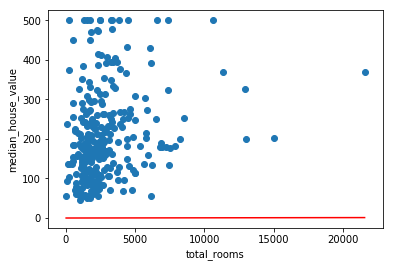

In [27]:
# Get the min and max total_rooms values.
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()

# Retrieve the final weight and bias generated during training.
weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

# Get the predicted median_house_values for the min and max total_rooms values.
y_0 = weight * x_0 + bias 
y_1 = weight * x_1 + bias

# Plot our regression line from (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')

# Label the graph axes.
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

# Plot a scatter plot from our data sample.
plt.scatter(sample["total_rooms"], sample["median_house_value"])

# Display graph.
plt.show()

These things suggest that we might get a much better line. 

## Tweaking Model Hyperparameters

In [34]:
def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
  """
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = train[[my_feature]]
  my_label = "median_house_value"
  targets = train[my_label]

  # Create feature columns
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
  
  # Create input functions
  training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
  prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = train.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")
  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Output a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

Training model...
RMSE (on training data):
  period 00 : 225.63
  period 01 : 214.42
  period 02 : 204.04
  period 03 : 194.62
  period 04 : 186.60
  period 05 : 180.00
  period 06 : 175.44
  period 07 : 171.40
  period 08 : 168.61
  period 09 : 166.96
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,119.5,207.3
std,98.5,116.0
min,0.1,15.0
25%,66.1,119.4
50%,96.1,180.4
75%,142.4,265.0
max,1714.8,500.0


Final RMSE (on training data): 166.96


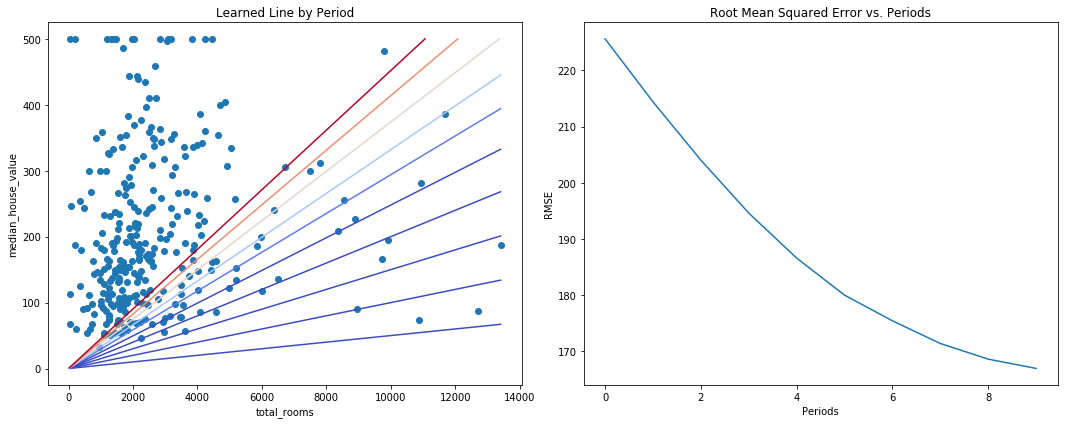

In [36]:
train_model(
    learning_rate=0.00002,
    steps=500,
    batch_size=5
)

### Rules for parameters tuning:

* Training error should steadily decrease, steeply at first, and should eventually plateau as training converges.
* If the training has not converged, try running it for longer.
* If the training error decreases too slowly, increasing the learning rate may help it decrease faster.
* But sometimes the exact opposite may happen if the learning rate is too high.
* If the training error varies wildly, try decreasing the learning rate.
* Lower learning rate plus larger number of steps or larger batch size is often a good combination.
* Very small batch sizes can also cause instability. First try larger values like 100 or 1000, and decrease until you see degradation.

## Using 'Population' as feature:

Training model...
RMSE (on training data):
  period 00 : 225.63
  period 01 : 214.62
  period 02 : 204.86
  period 03 : 196.26
  period 04 : 189.25
  period 05 : 183.70
  period 06 : 180.42
  period 07 : 178.24
  period 08 : 176.59
  period 09 : 176.03
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,119.5,207.3
std,96.0,116.0
min,0.3,15.0
25%,66.1,119.4
50%,97.6,180.4
75%,143.9,265.0
max,2983.7,500.0


Final RMSE (on training data): 176.03


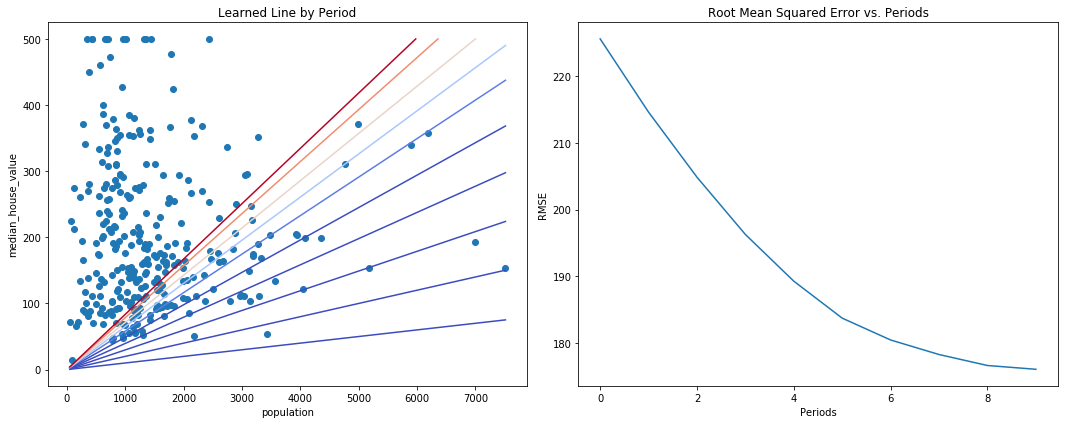

In [37]:
train_model(
    learning_rate=0.00002,
    steps=1000,
    batch_size=5,
    input_feature="population"
)

### Using Rooms_per_person

In [39]:
train["rooms_per_person"] = (train["total_rooms"] / train["population"])

Training model...
RMSE (on training data):
  period 00 : 212.74
  period 01 : 189.64
  period 02 : 170.27
  period 03 : 153.74
  period 04 : 140.66
  period 05 : 133.63
  period 06 : 131.38
  period 07 : 130.69
  period 08 : 131.56
  period 09 : 131.37
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,194.3,207.3
std,88.9,116.0
min,45.0,15.0
25%,159.4,119.4
50%,191.3,180.4
75%,218.4,265.0
max,4243.5,500.0


Final RMSE (on training data): 131.37


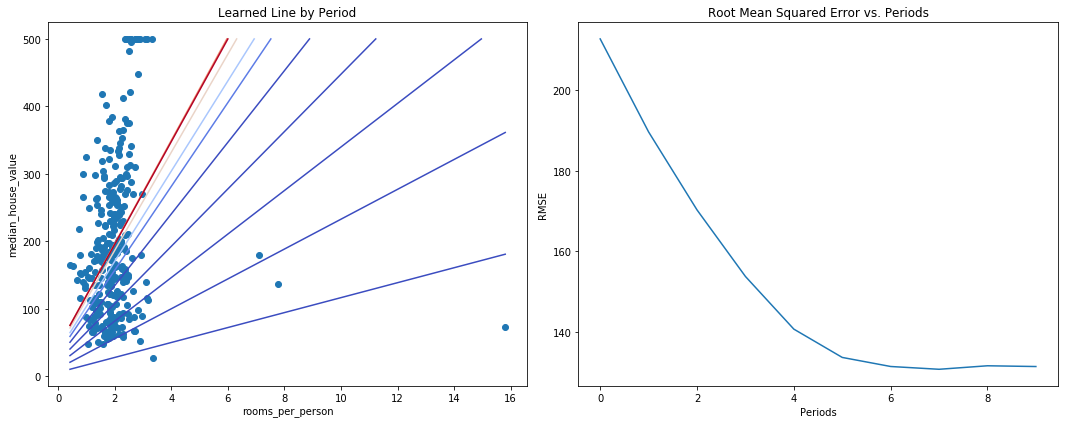

In [40]:
calibration_data = train_model(
    learning_rate=0.05,
    steps=500,
    batch_size=5,
    input_feature="rooms_per_person")